# Company database with no Gang of Four design patterns used

In [1]:
import sqlite3
from datetime import datetime, timedelta
import random

# Create a new SQLite database (or connect to an existing one)
conn = sqlite3.connect("company_database.db")
cursor = conn.cursor()

# Create the companies table if it doesn't exist
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS companies (
    id INTEGER PRIMARY KEY,
    ticker TEXT NOT NULL,
    name TEXT NOT NULL
)
"""
)

# Synthesize data for 10 companies
companies = [
    (1, "AAPL", "Apple Inc."),
    (2, "GOOGL", "Alphabet Inc."),
    (3, "MSFT", "Microsoft Corporation"),
    (4, "AMZN", "Amazon.com Inc."),
    (5, "TSLA", "Tesla Inc."),
    (6, "FB", "Meta Platforms Inc."),
    (7, "NVDA", "NVIDIA Corporation"),
    (8, "NFLX", "Netflix Inc."),
    (9, "ADBE", "Adobe Inc."),
    (10, "ORCL", "Oracle Corporation"),
]

# Insert data into the companies table
cursor.executemany(
    """
INSERT OR IGNORE INTO companies (id, ticker, name)
VALUES (?, ?, ?)
""",
    companies,
)

# Create the TimeSeries table
cursor.execute(
    """
CREATE TABLE IF NOT EXISTS TimeSeries (
    id INTEGER PRIMARY KEY,
    company_id INTEGER,
    value REAL,
    date TEXT,
    FOREIGN KEY (company_id) REFERENCES companies(id)
)
"""
)

# Generate synthetic data for TimeSeries table
start_date = datetime(2023, 1, 1)
num_entries = 100

time_series_data = []

for company in companies:
    company_id = company[0]
    for i in range(num_entries):
        date = start_date + timedelta(days=i)
        value = round(
            random.uniform(100, 500), 2
        )  # Generate a random value between 100 and 500
        time_series_data.append((company_id, value, date.strftime("%Y-%m-%d")))

# Insert data into the TimeSeries table
cursor.executemany(
    """
INSERT INTO TimeSeries (company_id, value, date)
VALUES (?, ?, ?)
""",
    time_series_data,
)

# Commit the transaction and close the connection
conn.commit()
conn.close()

In [2]:
import sqlite3
import pandas as pd
import numpy as np

# Define the Bollinger Band width as a global variable
bollinger_width = 2

# Define the Window Size for Movine Average
window_size = 20


class Company:
    def __init__(self, company_id, ticker, name):
        self.company_id = company_id
        self.ticker = ticker
        self.name = name
        self.time_series = None
        self.high_bollinger = None
        self.low_bollinger = None
        self.moving_average = None
        self.grade = None

    def load_time_series(self, conn):
        query = """
        SELECT date, value
        FROM TimeSeries
        WHERE company_id = ?
        ORDER BY date
        """
        self.time_series = pd.read_sql_query(query, conn, params=(self.company_id,))
        self.time_series["date"] = pd.to_datetime(self.time_series["date"])

    def calculate_bollinger_bands(self):
        rolling_mean = self.time_series["value"].rolling(window_size).mean()
        rolling_std = self.time_series["value"].rolling(window_size).std()
        self.moving_average = rolling_mean
        self.high_bollinger = rolling_mean + (rolling_std * bollinger_width)
        self.low_bollinger = rolling_mean - (rolling_std * bollinger_width)

    def assign_grade(self):
        latest_value = self.time_series["value"].iloc[-1]
        if latest_value > self.high_bollinger.iloc[-1]:
            self.grade = "A"
        elif latest_value < self.low_bollinger.iloc[-1]:
            self.grade = "C"
        else:
            self.grade = "B"

    def display(self):
        print(f"Company: {self.name} ({self.ticker})")
        print(f"Grade: {self.grade}")
        print("Time Series Data:")
        print(self.time_series.tail())
        print("Moving Average:")
        print(self.moving_average.tail())
        print("High Bollinger Band:")
        print(self.high_bollinger.tail())
        print("Low Bollinger Band:")
        print(self.low_bollinger.tail())


def get_company_by_ticker(ticker, conn):
    cursor = conn.cursor()
    query = "SELECT id, ticker, name FROM companies WHERE ticker = ?"
    cursor.execute(query, (ticker,))
    row = cursor.fetchone()
    if row:
        return Company(row[0], row[1], row[2])


def get_company_by_ticker_or_id(identifier, conn):
    cursor = conn.cursor()
    if isinstance(identifier, int):
        query = "SELECT id, ticker, name FROM companies WHERE id = ?"
        cursor.execute(query, (identifier,))
    else:
        query = "SELECT id, ticker, name FROM companies WHERE ticker = ?"
        cursor.execute(query, (identifier,))
    row = cursor.fetchone()
    if row:
        return Company(row[0], row[1], row[2])
    else:
        return None


# Example usage:
conn = sqlite3.connect("company_database.db")

# Get company by ticker or ID
company = get_company_by_ticker("GOOGL", conn)
if company:
    company.load_time_series(conn)
    company.calculate_bollinger_bands()
    company.assign_grade()
    company.display()

conn.close()

Company: Alphabet Inc. (GOOGL)
Grade: B
Time Series Data:
         date   value
95 2023-04-06  355.86
96 2023-04-07  424.97
97 2023-04-08  327.85
98 2023-04-09  206.75
99 2023-04-10  146.42
Moving Average:
95    292.4305
96    303.8530
97    311.8160
98    299.2475
99    301.0590
Name: value, dtype: float64
High Bollinger Band:
95    552.659247
96    566.400711
97    566.636997
98    548.418728
99    544.913056
Name: value, dtype: float64
Low Bollinger Band:
95    32.201753
96    41.305289
97    56.995003
98    50.076272
99    57.204944
Name: value, dtype: float64


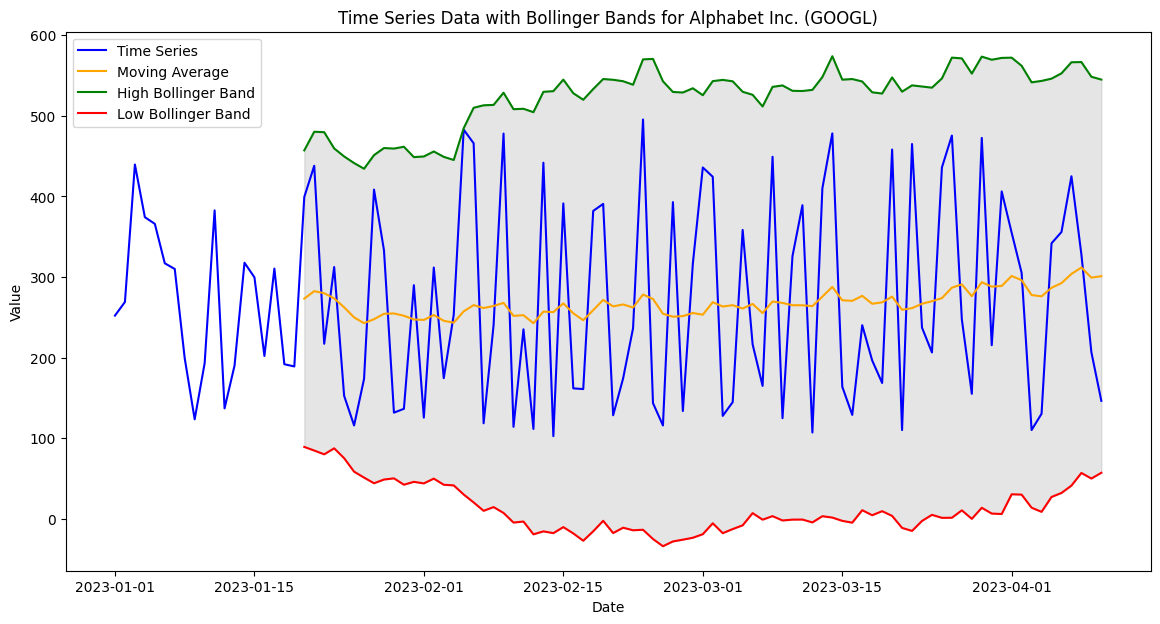

In [3]:
// Now can you write code using Seabourne or Matplotlib to plot the time series data for a company, and overlay the already calculate high bollinger, low bollinger, and moving average on the same plot? 

import matplotlib.pyplot as plt

# Plot the time series data along with Bollinger Bands and Moving Average
def plot_time_series_with_bollinger(company):
    plt.figure(figsize=(14, 7))
    plt.plot(company.time_series['date'], company.time_series['value'], label='Time Series', color='blue')
    plt.plot(company.time_series['date'], company.moving_average, label='Moving Average', color='orange')
    plt.plot(company.time_series['date'], company.high_bollinger, label='High Bollinger Band', color='green')
    plt.plot(company.time_series['date'], company.low_bollinger, label='Low Bollinger Band', color='red')
    plt.fill_between(company.time_series['date'], company.low_bollinger, company.high_bollinger, color='gray', alpha=0.2)
    plt.title(f'Time Series Data with Bollinger Bands for {company.name} ({company.ticker})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage:
plot_time_series_with_bollinger(company)